In [1]:
import json
import os
import shutil
import time
import warnings
from pprint import pprint

In [2]:
import gensim.parsing.preprocessing as gsp
import joblib
import matplotlib.pyplot as plt
import mlflow
import nltk
import numpy as np
import pandas as pd
import tensorflow_hub as hub
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from mlflow.models import infer_signature
from nltk import WordNetLemmatizer, PorterStemmer
from pandas import DataFrame
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from transformers import *
from xgboost import XGBClassifier

2024-08-16 09:30:18.751237: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 09:30:18.770001: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 09:30:18.774311: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-16 09:30:18.786901: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-16 09:30:20.312185: W tensorflow/compiler/tf2

In [3]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

MISC CONFIGURATION

In [4]:
plt.style.use("fivethirtyeight")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

PATHS

In [5]:
CACHED_QUESTIONS_FILE = 'cached_questions_2500.json'
MODELS_PATH = 'inferring_api/models'

NLTK PACKAGES

In [6]:
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /home/xavier/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/xavier/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

NLTK OBJECTS

In [7]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

To avoid having multiprocessing issues between BERT and the GridsearchCV

In [8]:
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

MLFlow

In [9]:
mlflow.set_tracking_uri(uri="http://localhost:8080")
mlflow.set_experiment("Supervised Learning Experiment")

<Experiment: artifact_location='mlflow-artifacts:/177264675439782594', creation_time=1723543849104, experiment_id='177264675439782594', last_update_time=1723543849104, lifecycle_stage='active', name='Supervised Learning Experiment', tags={}>

In [10]:
def load_cached_questions():
    """Load questions from the cache file."""
    with open(CACHED_QUESTIONS_FILE, 'r', encoding='utf-8') as f:
        return json.load(f)

In [11]:
def remove_last_saved_model():
    """Removes the content of the saved model."""
    shutil.rmtree(MODELS_PATH, ignore_errors=True)
    os.makedirs(MODELS_PATH, exist_ok=True)

In [12]:
def extract_and_clean_text(question: dict):
    """Create a new 'text' field for each question containing the cleaned, tokenized and lemmatized title + body."""
    title = question['title']
    body = question['body']
    text = f"{title} {body}"
    
    for filter in [gsp.strip_tags,
                   gsp.strip_punctuation,
                   gsp.strip_multiple_whitespaces,
                   gsp.strip_numeric,
                   gsp.remove_stopwords,
                   gsp.strip_short,
                   gsp.lower_to_unicode]:
        text = filter(text)
        
    tokenized_text = nltk.tokenize.word_tokenize(text)

    # words_stemmed = (stemmer.stem(w) for w in words_without_short_words)
    words_lemmatized = [lemmatizer.lemmatize(w) for w in tokenized_text]
    question['text'] = " ".join(words_lemmatized)

    # bigrams = nltk.bigrams(tokenized_text)
    # question['bigrams'] = [' '.join(bigram) for bigram in bigrams]

    # trigrams = nltk.trigrams(tokenized_text)
    # question['trigrams'] = [' '.join(trigram) for trigram in trigrams]
    
    return question

In [13]:
def bert_inp_fct(sentences, bert_tokenizer, max_length):
    """Returns BERT variables for its prediction."""
    input_ids = []
    token_type_ids = []
    attention_mask = []
    bert_inp_tot = []
    
    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens=True,
                                              max_length=max_length,
                                              padding='max_length',
                                              return_attention_mask=True,
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
        
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0],
                             bert_inp['token_type_ids'][0],
                             bert_inp['attention_mask'][0]))
        
    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot

In [14]:
def transform_text_using_BERT(model, model_type, sentences, max_length, b_size):
    """Transform the text of the question's body and title into BERT embeddings."""
    # We don't want to use the cleaned text field with BERT, only title + " " + body
    sentences = [f"{sentence[1]} {sentence[0]}" for sentence in sentences.iterrows()]
    
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    
    time1 = time.time()
    for step in range(len(sentences) // batch_size):
        idx = step * batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx + batch_size],
                                                                               bert_tokenizer, max_length)
        outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
        
        last_hidden_states = outputs.last_hidden_state
        if step == 0:
            last_hidden_states_tot = last_hidden_states
        else:
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot, last_hidden_states))
            
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1, 0)
    print(f"BERT processing time:{time2}s\n")
    
    return features_bert

In [15]:
def transform_text_using_USE(sentences, b_size):
    """Transform the text of the question's body and title into USE embeddings."""
    # We don't want to use the cleaned text field with USE, only title + " " + body
    sentences = [f"{sentence[1]} {sentence[0]}" for sentence in sentences.iterrows()]
    
    batch_size = b_size
    time1 = time.time()
    
    us_encoder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
    
    for step in range(len(sentences) // batch_size):
        idx = step * batch_size
        feat = us_encoder(sentences[idx:idx + batch_size])
        
        if step == 0:
            features = feat
        else:
            features = np.concatenate((features, feat))
            
    time2 = np.round(time.time() - time1, 0)
    print(f"USE processing time:{time2}s\n")
    
    return features

In [16]:
def transform_text(questions_without_tags, text_transformation_method):
    """Transform the question text/body and title into words embeddings."""
    if text_transformation_method == "Doc2VEC":
        return transform_text_using_Doc2VEC(questions_without_tags["text"])
        
    elif text_transformation_method == "BERT":
        max_length = 64
        batch_size = 10
        model_type = 'bert-base-uncased'
        model = TFAutoModel.from_pretrained(model_type)
        
        return transform_text_using_BERT(model, model_type, questions_without_tags, max_length, batch_size)
        
    elif text_transformation_method == "USE":
        batch_size = 10
        return transform_text_using_USE(questions_without_tags, batch_size)

In [17]:
def transform_text_using_Doc2VEC(questions_without_tags):
    """Transform the text of the question's body and title into Doc2VEC embeddings."""
    time1 = time.time()
    tagged_text = [TaggedDocument(words=text, tags=[str(index)])
                   for index, text in enumerate(questions_without_tags)]

    # dm=0 for DBOW, dm=1 for PV-DM
    model = Doc2Vec(vector_size=30, min_count=2, epochs=80, dm=0)
    model.build_vocab(tagged_text)
    
    model.train(tagged_text, total_examples=model.corpus_count, epochs=model.epochs)
    embedded_text = [model.infer_vector(text.split(" ")) for text in questions_without_tags]
    
    time2 = np.round(time.time() - time1, 0)
    print(f"Doc2VEC processing time:{time2}s\n")
    
    return embedded_text

In [18]:
def create_results_plot(results):
    """Generate the plot showing the performance with each words embedding method."""
    performance_plot = results.plot(kind="bar", x="words_embedding_method", figsize=(15, 8), rot=0,
                                    title="Models Performance Sorted by Hamming Loss")
    
    performance_plot.legend([f"Hamming Loss", f"Jaccard Score"])
    performance_plot.title.set_size(20)
    performance_plot.set(xlabel=None)
    
    # performance_plot.get_figure().savefig(f"{RESULTS_PATH}/performance_plot.png", bbox_inches='tight')
    plt.show()
    plt.close()

In [19]:
def perform_supervised_modeling(questions):
    """Find the best model using a GridSearchCV hyperoptimization for each words embedding method."""
    questions_df = DataFrame(questions).head(500)
    
    tags = MultiLabelBinarizer().fit_transform(questions_df['tags'])
    questions_df['tags'].to_json(f"{MODELS_PATH}/tags.json")
    
    questions_without_tags = questions_df.drop(columns=['tags'], axis=1)
    
    results_df = DataFrame(columns=["words_embedding_method", "hamming_loss", "jaccard_score"])
    models = {}
    for words_embedding_method in [
        "Doc2VEC",
        "BERT",
        "USE"
    ]:
        print(f"Starting supervised learning with words embedding method:{words_embedding_method}.\n")
        
        transformed_text = transform_text(questions_without_tags, words_embedding_method)
        
        x_train, x_test, y_train, y_test = train_test_split(transformed_text, tags, test_size=0.2, random_state=42)
        print(f"training set size:{len(x_train)}, test set size:{len(x_test)}\n")
        
        default_model = XGBClassifier(n_estimators=50)
        # default_hyperparameters = {'estimator__max_depth': range(2, 12)}
        default_hyperparameters = {'estimator__max_depth': [2]}

        grid_search_cv = GridSearchCV(MultiOutputClassifier(estimator=default_model), default_hyperparameters,
                                      cv=2,
                                      scoring=make_scorer(metrics.hamming_loss, greater_is_better=False),
                                      n_jobs=-1,
                                      verbose=3
                                      )
        grid_search_cv.fit(x_train, y_train)
        
        best_parameters = grid_search_cv.best_params_
        print(f"\nBest mean squared score:{grid_search_cv.best_score_} with params:{best_parameters}")
        
        best_model = grid_search_cv.best_estimator_
        models[words_embedding_method] = best_model
        
        predictions_test_y = grid_search_cv.best_estimator_.predict(x_test)
        
        hamming_loss = metrics.hamming_loss(y_true=y_test, y_pred=predictions_test_y)
        jaccard_score = metrics.jaccard_score(y_true=y_test, y_pred=predictions_test_y, average='samples')
        print(f"Hamming loss:{hamming_loss}, jaccard_score:{jaccard_score}\n")
        
        results_df.loc[len(results_df)] = [words_embedding_method, hamming_loss, jaccard_score]
        
        send_results_to_mlflow(default_hyperparameters, best_model, hamming_loss, jaccard_score,
                               words_embedding_method, x_train)
        
    results_df.sort_values(f"hamming_loss", ascending=True, inplace=True)
    create_results_plot(results_df)
    
    save_best_model(models, results_df)

In [20]:
def save_best_model(models, results_df):
    """Save the best model based on the hamming loss."""
    best_words_embedding_method = results_df.head(1)['words_embedding_method'].values[0]
    joblib.dump(models[best_words_embedding_method], f"{MODELS_PATH}/best_supervised_model.model")

In [21]:
def send_results_to_mlflow(default_hyperparameters, best_model, hamming_loss, jaccard_score, words_embedding_method,
                           x_train):
    """Send data to the MLFlow server."""
    with mlflow.start_run():
        mlflow.log_params(default_hyperparameters)
        
        mlflow.log_metric("hamming_loss", hamming_loss)
        mlflow.log_metric("jaccard_score", jaccard_score)
        
        mlflow.set_tag("Words embedding method", words_embedding_method)
        
        signature = infer_signature(x_train, best_model.predict(x_train))
        
        mlflow.sklearn.log_model(
            sk_model=best_model,
            artifact_path="supervised-models",
            signature=signature,
            input_example=x_train,
            registered_model_name="XGBoost",
        )

Starting supervised learning script. Please make sure you have a local MLFlow server running.

2500 questions loaded from cache.

Texts extracted and cleaned.

Starting supervised learning with words embedding method:Doc2VEC.

Doc2VEC processing time:5.0s

training set size:400, test set size:100

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2] END ...........estimator__max_depth=2;, score=-0.005 total time=   8.7s
[CV 2/2] END ...........estimator__max_depth=2;, score=-0.005 total time=   9.2s

Best mean squared score:-0.00514792899408284 with params:{'estimator__max_depth': 2}
Hamming loss:0.00507396449704142, jaccard_score:0.0075



Registered model 'XGBoost' already exists. Creating a new version of this model...
2024/08/16 09:50:34 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost, version 50
Created version '50' of model 'XGBoost'.
2024/08/16 09:50:43 WARNING mlflow.models.model: Failed to validate serving input example {
  "dataframe_split": {
    "data": [
      [
        -0.00014729997201357037,
        -0.01435302384197712,
        -0.014778593555092812,
        -0.001290721702389419,
        0.004214851185679436,
        0.009394369088113308,
        0.0005987703916616738,
        0.008221684023737907,
        0.005793025251477957,
        0.01190859917551279,
        0.0012141247279942036,
        0.013116780668497086,
        0.01140775065869093,
        -0.008803651668131351,
        -0.007215703371912241,
        0.008892846293747425,
        0.00816135760396719,
        0.011228672228753567,
        -0.00359171628952026

Starting supervised learning with words embedding method:BERT.



loading configuration file config.json from cache at /home/xavier/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.44.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file model.safetensors from cache at /home/xavier/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f72

1/1 [==============================] - 0s 22ms/step
BERT processing time:11.0s

training set size:400, test set size:100

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2] END ...........estimator__max_depth=2;, score=-0.005 total time= 1.3min
[CV 2/2] END ...........estimator__max_depth=2;, score=-0.005 total time= 1.4min

Best mean squared score:-0.004778106508875739 with params:{'estimator__max_depth': 2}
Hamming loss:0.004718934911242603, jaccard_score:0.085



Registered model 'XGBoost' already exists. Creating a new version of this model...
2024/08/16 10:28:00 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost, version 51
Created version '51' of model 'XGBoost'.
2024/08/16 10:28:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run agreeable-moose-513 at: http://localhost:8080/#/experiments/177264675439782594/runs/dcd404c163ca4e8a8da39db27588f8d3.
2024/08/16 10:28:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/177264675439782594.


Starting supervised learning with words embedding method:USE.

USE processing time:138.0s

training set size:400, test set size:100

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2] END ...........estimator__max_depth=2;, score=-0.004 total time=  51.7s
[CV 2/2] END ...........estimator__max_depth=2;, score=-0.004 total time=  51.4s

Best mean squared score:-0.004375 with params:{'estimator__max_depth': 2}
Hamming loss:0.004260355029585799, jaccard_score:0.20650000000000002



Registered model 'XGBoost' already exists. Creating a new version of this model...
2024/08/16 11:02:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost, version 52
Created version '52' of model 'XGBoost'.
2024/08/16 11:02:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run charming-shoat-896 at: http://localhost:8080/#/experiments/177264675439782594/runs/4e9f4e5a2fc54ddc98c750cdbb57be91.
2024/08/16 11:02:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/177264675439782594.


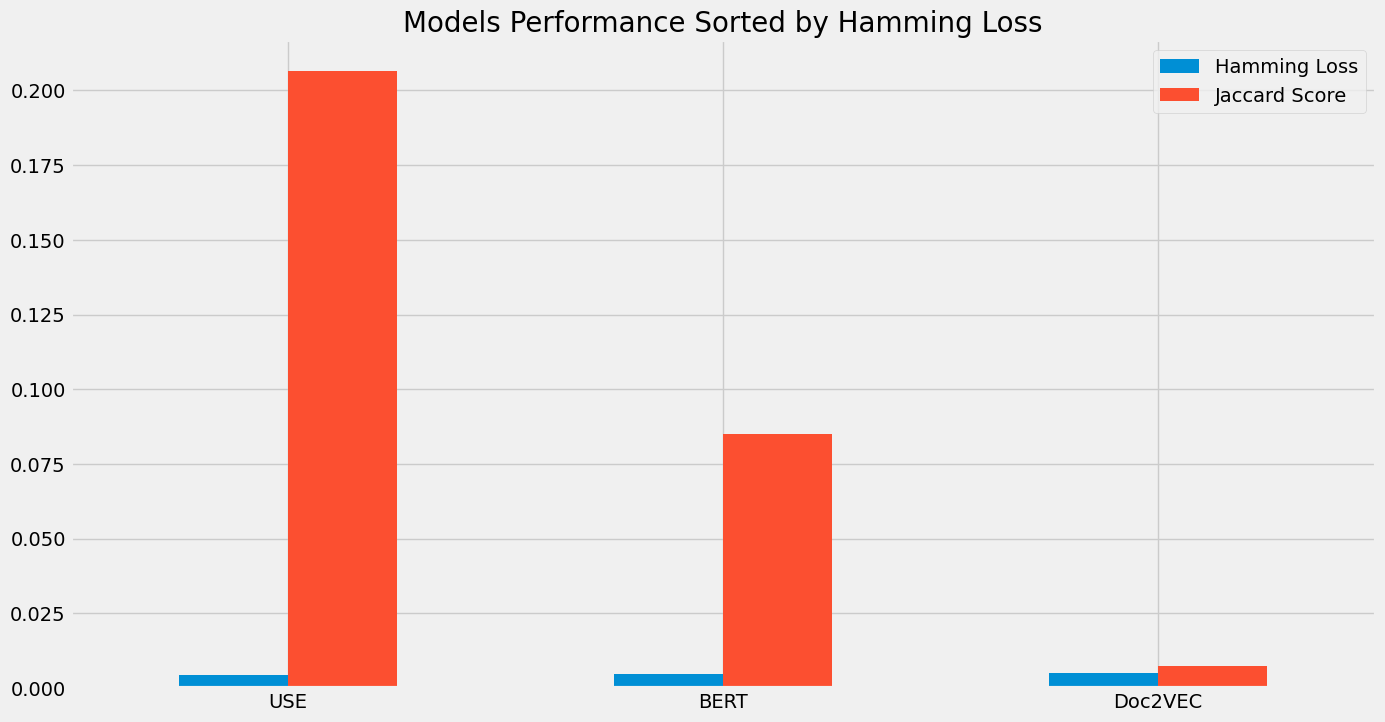


Supervised learning now finished.



In [22]:
print("Starting supervised learning script. Please make sure you have a local MLFlow server running.\n")
remove_last_saved_model()

json_questions = load_cached_questions()

questions = [{
    "body": question['body'],
    "tags": question['tags'],
    "title": question['title']
} for question in json_questions]

print(f"{len(questions)} questions loaded from cache.\n")

questions = list(map(extract_and_clean_text, questions))
print("Texts extracted and cleaned.\n")

perform_supervised_modeling(questions)

print("\nSupervised learning now finished.\n")